In [17]:
from matplotlib import pyplot as plt
import numpy as np
import torch

import torchvision
from torchvision import datasets, transforms

from collections import Counter
from torch.utils.data import random_split

from torch.utils.data import DataLoader

from torchvision import models
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import time

In [18]:
seed = 10
torch.manual_seed(seed)

category_index = 8
n_val = 5000

data_path = '/cifar-10-batches-py'
torch.set_default_dtype(torch.double)

Function for loading the Cifar10 dataset.

The method will have to be run twice.
After running the method for the first time we get create a normalizer from the std and mean of the images. The method is then ran for a second time with the normalizer as the preprocessor.

Loading the CIFAR-10 dataset as tensors.

In [19]:
transformed_cifar10_train_val = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

Files already downloaded and verified


Stacking the set of images into a single tensor. We then create a normalizer for the dataset around the mean and standard deviation of the 3 dimensions (height, width channel (color)).

In [20]:
imgs = torch.stack([img for img, _ in transformed_cifar10_train_val])

normalizer = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = imgs.mean(dim=(0, 2, 3)), std = imgs.std(dim=(0, 2, 3)))])

Loading the dataset as tensors for training+validation and testing. This time we apply the composition of transforms.

In [21]:
normalized_cifar10_train_val = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform = normalizer
)


normalized_cifar10_test = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform = normalizer
)

Plotting image before and after transformation

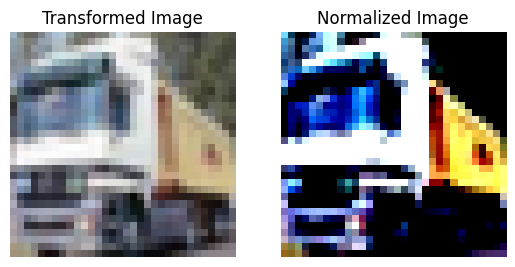

In [22]:
img, _ = transformed_cifar10_train_val[1]
img_t, _ = normalized_cifar10_train_val[1]

# Clip the values between 0 and 1
img = np.clip(img, 0, 1)
img_t = np.clip(img_t, 0, 1)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(img.permute(1, 2, 0))
ax[0].axis("off")
ax[0].set_title("Transformed Image")

ax[1].imshow(img_t.permute(1, 2, 0))
ax[1].axis("off")
ax[1].set_title("Normalized Image")

plt.show()

As this is a binary classification problem where we only want to identify whether an image is a ship or not, we can set the labels that are "ship" to true. We set all other labels to false.

Splitting the training and validation set randomly.

In [23]:
n_train = len(transformed_cifar10_train_val)-n_val

normalized_cifar10_train_split, normalized_cifar10_val_split = random_split(
    normalized_cifar10_train_val,
    [n_train, n_val],

    generator=torch.Generator().manual_seed(seed)
)

print("Size of the train dataset:        ", len(normalized_cifar10_train_split))
print("Size of the validation dataset:   ", len(normalized_cifar10_val_split))
print("Size of the test dataset:         ", len(normalized_cifar10_test))

Counter([label for _, label in normalized_cifar10_train_split])

Size of the train dataset:         45000
Size of the validation dataset:    5000
Size of the test dataset:          10000


Counter({8: 4486,
         7: 4486,
         1: 4512,
         6: 4510,
         3: 4516,
         5: 4487,
         4: 4499,
         2: 4483,
         0: 4518,
         9: 4503})

Making this a binary clasification problem, where our designated category index is set to 1, and all other categories is set to 0. (The labels)

In [24]:
train10 = [(img, int(label == category_index)) for img, label in normalized_cifar10_train_split]
val10 = [(img, int(label == category_index)) for img, label in normalized_cifar10_val_split]

train_loader = DataLoader(train10, batch_size=64, shuffle=False)
val_loader = DataLoader(val10, batch_size=64, shuffle=False)

All of the models where found here: https://pytorch.org/vision/0.8/models.html

Theese where the most used models, and we use all of them to see what models performes the best

In [25]:
import torchvision.models as models

def modify_for_binary_classification(model):
    if isinstance(model, models.ResNet):
        model.fc = torch.nn.Linear(model.fc.in_features, 1)
    elif isinstance(model, models.AlexNet) or isinstance(model, models.vgg.VGG):
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 1)
    elif isinstance(model, models.SqueezeNet):
        model.classifier[1] = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    elif isinstance(model, models.DenseNet):
        model.classifier = torch.nn.Linear(model.classifier.in_features, 1)
    elif isinstance(model, models.Inception3):
        model.AuxLogits.fc = torch.nn.Linear(model.AuxLogits.fc.in_features, 1)
        model.fc = torch.nn.Linear(model.fc.in_features, 1)
    elif isinstance(model, models.GoogLeNet):
        model.fc = torch.nn.Linear(model.fc.in_features, 1)
    elif isinstance(model, models.ShuffleNetV2):
        model.fc = torch.nn.Linear(model.fc.in_features, 1)
    elif isinstance(model, models.MobileNetV2):
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 1)
    else:
        raise NotImplementedError("Unknown model type")
    return model

model_list = [
    models.resnet18(pretrained=True),
    models.alexnet(pretrained=True),
    models.squeezenet1_0(pretrained=True),
    models.googlenet(pretrained=True),
    models.shufflenet_v2_x1_0(pretrained=True),
    models.mobilenet_v2(pretrained=True),
]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weight

Loading pre-trained models and modifying the last layer. We are doing binary classification, so we think we only need one node in the final layer.

We use Binary Cross Entropy as it should be suitable for binary classification problems (add reasoning and explanation). We use nn.BCEWithLogitsLoss() as it combines the sigmoid activation function and the BCE into a single class.

The optimizer we use is Adam, and we will begin with a learning rate of 0.001, just because it is a commonly used learning rate.

In [29]:
loss_function = torch.nn.BCEWithLogitsLoss()

device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [27]:
def train(model,loader):
  try:
    optimizer = optim.Adam(model.parameters(),  lr=0.001)

    model.to(device)

    num_epochs = 2

    model.train()
    optimizer.zero_grad(set_to_none=True)
    i = 0
    for epoch in range(num_epochs):
      start_time = time.time()
      running_loss = 0

      for inputs, labels in loader:
        i += 1
        print(i)
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        outputs = model(inputs).squeeze()
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

      end_time = time.time()
      epoch_time = end_time - start_time
      lossData = running_loss / len(loader)
      print(epoch)
      printModelInfo(model, epoch, epoch_time, lossData)
  except Exception as e:
    printModelInfo(model, e=e)

def printModelInfo(model, epoch=None, epoch_time=None, lossData=None, e=None):
  if(e != None):
    print()
    print("-"*50)
    print(f"|{'Model: ' + type(model).__name__:^25}|{('Error: ' + str(e)):^25}|")
    return

  if(epoch == 0):
    modelTitle = "Model name"
    epochTitle = "Epoch Nr"
    timeTitle = "Time (s)"
    lossTitle = "Loss (%)"
    print()
    print("-"*50)
    print(f'|{modelTitle:^15}|{epochTitle:^10}|{timeTitle:^10}|{lossTitle:^10}|')
    print("-"*50)

  modelName = (f'{type(model).__name__}')
  epochNr = (f'Nr.{epoch + 1}')
  time = (f'{epoch_time:.2f}s')
  lossD = (f'{100 * lossData:.2f}%')

  print(f'|{modelName:^15}|{epochNr:^10}|{time:^10}|{lossD:^10}|')


In [28]:
for model in model_list:
  model = modify_for_binary_classification(model)
  train(model, train_loader)
  print("-"*50)

1
2
3
4


KeyboardInterrupt: ignored

In [ ]:
def compute_accuracy_on_gpu(model, loader):
  try:
    # set the model to evaluation mode
    model.eval()

    # Initialize counters for number of correctly and total labeled samples
    correct = 0
    total = 0

    # Turn off gradient computation since we are not training   
    with torch.no_grad():
        # Iterate over the data loader
        for img, labels in loader:
            # Move the input and target tensors to the specified device
            img = img.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)
            
            # Forward pass through the model to get the outputs
            outputs = model(img)

            # Apply sigmoid activation function
            sigmoid = torch.sigmoid(outputs).squeeze()

            # Threshold the outputs to get the predicted class
            predicted = (sigmoid > 0.5).long()

            # Update the counters for correctly and total labeled samples
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    # Compute and return the accuracy  
    return correct/total
  except Exception as e:
    return e


for model in model_list:
  modelName = "Model: " + type(model).__name__
  trainingAccuracy = compute_accuracy_on_gpu(model, train_loader)

  if isinstance(trainingAccuracy, Exception):
    print(f"Error on model {type(model).__name__}" )
    continue
  
  ValidationAccuracy = compute_accuracy_on_gpu(model, val_loader)

  trainString = (f"Training Accuracy: {100 * trainingAccuracy:.2f}%")
  valString = (f"Validation Accuracy: {100 * ValidationAccuracy:.2f}%")

  print(f'|{modelName:^25}|{trainString:^30}|{valString:^30}|')

In [ ]:
'''
            # Get the index of the class with the highest score
            _, predicted = torch.max(outputs, dim=1)

            # Update the counters for correctly and total labeled samples
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
'''